# Explore the NDVI Data

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/Users/tommylees/github/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')

assert data_dir.exists()

In [3]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

## Open data and initial explore

In [147]:
vci = xr.open_dataset(data_dir / 'interim' / 'VCI_preprocessed' / 'data_kenya.nc')
vci = vci.sortby('lat')
vci

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 454)
Coordinates:
  * time     (time) datetime64[ns] 1981-08-31 1981-09-30 ... 2019-05-31
  * lon      (lon) float64 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * lat      (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
Data variables:
    VCI      (time, lat, lon) float64 39.36 18.57 19.15 12.16 ... 0.0 30.86 0.0

In [143]:
p = xr.open_dataset(
    data_dir / 'interim' / 'chirps_preprocessed' / 'data_kenya.nc'
)
p

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 464)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-31 1981-02-28 ... 2019-08-31
  * lon      (lon) float32 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * lat      (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
Data variables:
    precip   (time, lat, lon) float64 ...

In [144]:
ds = xr.open_dataset(
    data_dir / 'interim' / 'ndvi_preprocessed' / 'data_kenya.nc'
)
ds

<xarray.Dataset>
Dimensions:  (lat: 448, lon: 352, time: 458)
Coordinates:
  * time     (time) datetime64[ns] 1981-06-30 1981-07-31 ... 2019-07-31
  * lat      (lat) float32 -5.176438 -5.175003 -5.126424 ... 5.9749985 5.9766603
  * lon      (lon) float32 33.524994 33.529655 33.574997 ... 42.274994 42.280872
Data variables:
    ndvi     (time, lat, lon) float32 ...

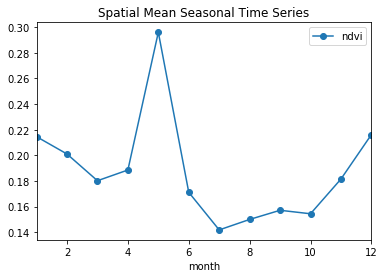

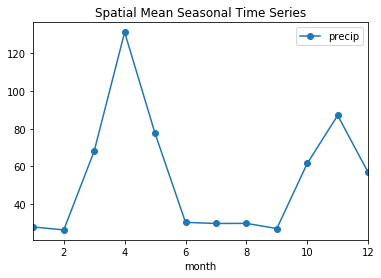

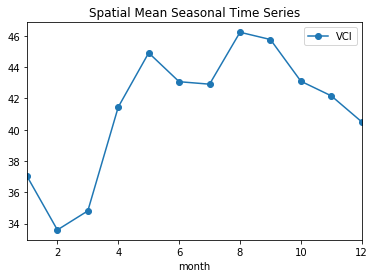

In [148]:
from scripts.drafts.plotting_utils import plot_seasonality, plot_normalised_seasonality

fig, ax = plt.subplots()
plot_seasonality(ds, ax=ax);
fig, ax = plt.subplots()
plot_seasonality(p, ax=ax);
fig, ax = plt.subplots()
plot_seasonality(vci, ax=ax);

Signature: plot_seasonality(ds, ax=None, ylabel=None, double_year=False, variance=False)
Docstring:
Plot the monthly seasonality of the dataset

Arguments:
---------
: ds (xr.Dataset)
: ylabel (str, None)
    what is the y-axis label?
: double_year (bool)
    Do you want to view 2 seasonal cycles to better visualise winter months
: variance (bool)
    Do you want +- 1SD 'intervals' plotted?

TODO: explore seaborn to see if there is a better way to plot uncertainties.
      Main Q: what is the format data must be in to get uncertainties of
       +- 1SD?
File:      ~/github/ml_drought/scripts/drafts/plotting_utils.py
Type:      function


### errors in some months:
- 2018-05-31
- 2016-08-31

In [120]:
valid_times = [
    t for t in ds.time.values
    if not np.isin(
        pd.to_datetime(t), 
        [pd.to_datetime('2018-05-31'), pd.to_datetime('2016-08-31')]
    )
]
ds = ds.sel(time=valid_times)

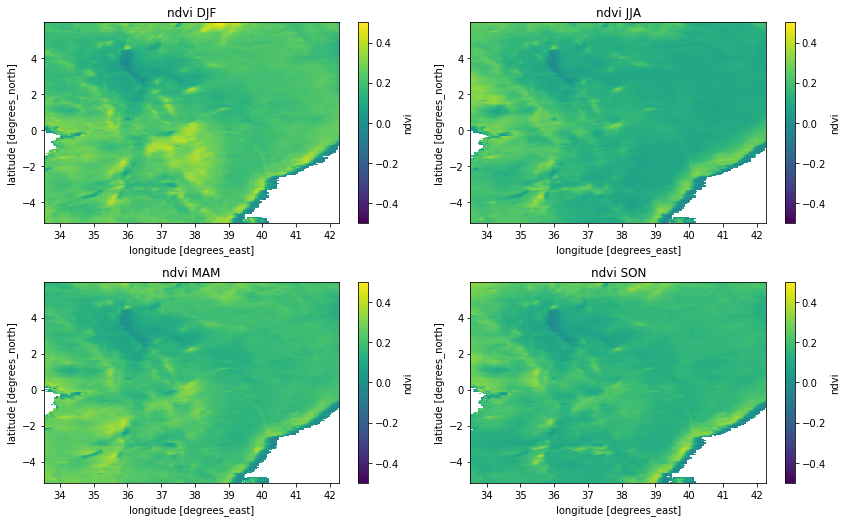

In [121]:
from scripts.drafts.plotting_utils import plot_seasonal_spatial_means

seas = (
    ds
    .groupby('time.season')
    .mean(dim=['time']).ndvi
)

plot_seasonal_spatial_means(seas, **{'vmin':-0.5, 'vmax':0.5});

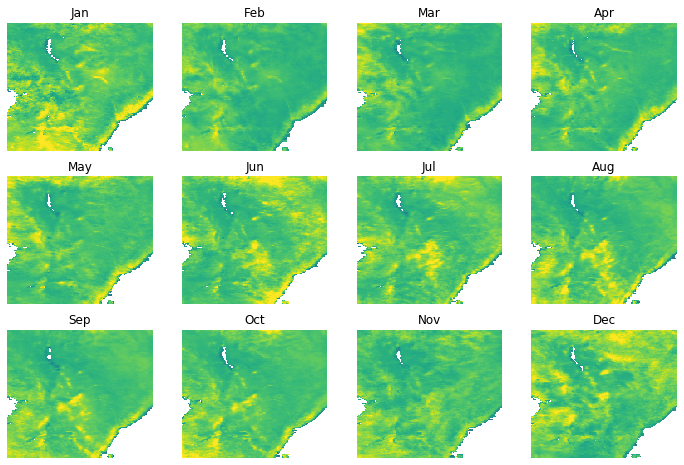

In [134]:
import calendar
# ds.groupby('time.month').mean(dim='time')

fig, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12, 8))
for i in range(0, 12):
    ax_ix = np.unravel_index(i, (3, 4))
    ax = axs[ax_ix]
    ds.ndvi.isel(time=i).plot(ax=ax, add_colorbar=False, vmin=-0.4, vmax=0.4)
    ax.set_title(calendar.month_abbr[i+1])
    ax.axis('off')

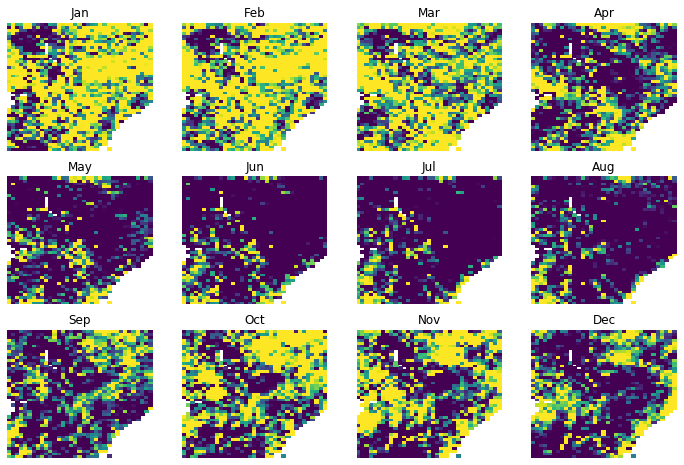

In [142]:
fig, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12, 8))
for i in range(0, 12):
    ax_ix = np.unravel_index(i, (3, 4))
    ax = axs[ax_ix]
    vci.VCI.isel(time=i).plot(ax=ax, add_colorbar=False, vmin=30, vmax=70)
    ax.set_title(calendar.month_abbr[i+1])
    ax.axis('off')

## Dynamic plotting to find errored timesteps
### errors in some months:
- 2018-05-31
- 2016-08-31

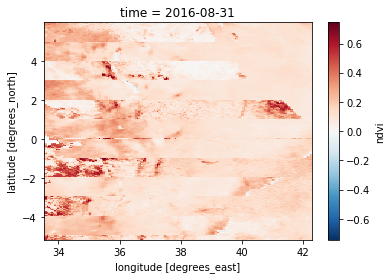

In [109]:
# (ds
#  .sel(time=ds.time.dt.season == 'JJA')
#  .isel(time=slice(-7, -1))
#  .ndvi.mean(dim='time').plot()
# )

(ds
 .sel(time=ds.time.dt.season == 'JJA')
 .isel(time=-9)
 .ndvi.plot()
)

In [72]:
(ds
 .sel(time=ds.time.dt.season == 'MAM')
)

<xarray.Dataset>
Dimensions:  (lat: 448, lon: 352, time: 114)
Coordinates:
  * time     (time) datetime64[ns] 1982-03-31 1982-04-30 ... 2019-05-31
  * lat      (lat) float32 -5.176438 -5.175003 -5.126424 ... 5.9749985 5.9766603
  * lon      (lon) float32 33.524994 33.529655 33.574997 ... 42.274994 42.280872
Data variables:
    ndvi     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan